### 一.联合概率分布
上一节我们介绍了线性回归的贝叶斯估计，它的图模型结构如下  
![avatar](./source/15_VI_贝叶斯线性回归图模型.png)
为了方便，我们将$\beta$看做一个常数，回忆一下上一节，我们的似然函数和共轭先验如下：   

$$
p(t\mid w)=\prod_{n=1}^N N(t_n\mid w^T\phi(x_n),\beta^{-1})\\
p(w\mid \alpha)=N(w\mid 0,\alpha^{-1}I)
$$  
这里，$X=\{x_1,x_2,...,x_N\}$，$I$为单位矩阵，与上一节给$\alpha$取定值不同，我们这里将$\alpha$看做来源于一个Gamma分布，即   
$$
p(\alpha)=Gam(\alpha\mid a_0,b_0)
$$   
所以，所有变量上的联合概率分布就有了   

$$
p(t,w,\alpha)=p(t\mid w)p(w\mid\alpha)p(\alpha)
$$

### 二.变分分布
接下来，我们就是要构建一个变分分布$q(w,\alpha)$去近似后验概率分布$p(w,\alpha\mid t)$，利用平均场假设，令：   

$$
q(w,\alpha)=q(w)q(\alpha)
$$  

根据VI第一节最后推导的公式，我们可以直接写出最优解：   

$$
ln\ q^*(\alpha)=ln\ p(\alpha)+E_w[ln\ p(w\mid\alpha)]+const\\
=(a_0-1)ln\ \alpha-b_0\alpha+\frac{M}{2}ln\ \alpha-\frac{\alpha}{2}E[w^Tw]+const
$$  

可以发现这个Gamma分布取对数的形式，通过观察系数项，我们有  

$$
q^*(\alpha)=Gam(a\mid a_N,b_N)
$$  

其中  

$$
a_N=a_0+\frac{M}{2}\\
b_N=b_0+\frac{1}{2}E[w^Tw]
$$  

同样的方式，我们可以求解$q^*(w)$:   

$$
ln\ q^*(w)=ln\ p(t\mid w)+E_\alpha[ln\ p(w\mid \alpha)]+const\\
=-\frac{\beta}{2}\sum_{n=1}^N\left \{w^T\phi(x_n)-t_n\right \}^2-\frac{1}{2}E[\alpha]w^Tw+const\\
=-\frac{1}{2}w^T(E[\alpha]I+\beta\Phi^T\Phi)w+\beta w^T\Phi^Tt+const
$$  

可以发现这是关于$w$的二次型，所以$q^*(w)$是一个高斯分布，通过配方可以得到：   

$$
q^*(w)=N(w\mid m_N,S_N)
$$  

其中   

$$
m_N=\beta S_N\Phi^Tt\\
S_N=(E[\alpha]I+\beta\Phi^T\Phi)^{-1}
$$  

细心的同学已经发现了，把$E[\alpha]$换成$\alpha$就是上一节推导出来的结果

### 三.迭代求解

可以发现$q^*(w)$与$q^*(\alpha)$之间是相互耦合的，$q^*(w)$中需要用到$E[\alpha]$，而$q^*(\alpha)$中需要用到$E[w^Tw]$，而根据Gamma分布和高斯分布的性质，我们可以很方便的写出这两个期望的求解公式   

$$
E[\alpha]=\frac{a_N}{b_N}\\
E[w^Tw]=m_N^Tm_N+Tr(S_N)
$$  

那么，我们初始随意为$E[\alpha]$赋予一个大于0的值，就可以迭代起来了：$E_0[\alpha]\rightarrow E_0[w^Tw]\rightarrow E_1[\alpha]\rightarrow E_1[w^Tw]\rightarrow \cdots$

### 四.应用：预测分布
对于新的样本点$\hat{x}$，我们需要给出预测$\hat{t}$，其概率预测同样使用上一节的贝叶斯积分，只不过将后验分布替换成变分分布   

$$
p(\hat{t}\mid \hat{x},t)=\int p(\hat{t}\mid\hat{x},w)p(w\mid t)dw\\
\simeq \int p(\hat{t}\mid\hat{x},w)q(w)dw\\
=\int N(\hat{t}\mid w^T\phi(\hat{x}),\beta^{-1})N(w\mid m_N,S_N)dw\\
=N(\hat{t}\mid m_N^T\phi(\hat{x}),\sigma^2(\hat{x}))
$$  

这里$\sigma^2(\hat{x})=\frac{1}{\beta}+\phi(\hat{x})^TS_N\phi(\hat{x})$

 ### 五.代码实现

In [1]:
"""
线性回归的vi实现，代码封装到ml_models.vi中
"""
import numpy as np
import matplotlib.pyplot as plt


class LinearRegression(object):
    def __init__(self, basis_func=None, beta=1e-12, tol=1e-5, epochs=100):
        """
        :param basis_func: list,基函数列表，包括rbf,sigmoid,poly_{num},linear，默认None为linear，其中poly_{num}中的{num}表示多项式的最高阶数
        :param beta: 生成t标签的高斯噪声，这里可以设置低一点
        :param tol:  两次迭代参数平均绝对值变化小于tol则停止
        :param epochs: 默认迭代次数
        """
        if basis_func is None:
            self.basis_func = ['linear']
        else:
            self.basis_func = basis_func
        self.beta = beta
        self.tol = tol
        self.epochs = epochs
        # 特征均值、标准差
        self.feature_mean = None
        self.feature_std = None
        # 训练参数，也就是m_N
        self.w = None

    def _map_basis(self, X):
        """
        将X进行基函数映射
        :param X:
        :return:
        """
        x_list = []
        for basis_func in self.basis_func:
            if basis_func == "linear":
                x_list.append(X)
            elif basis_func == "rbf":
                x_list.append(np.exp(-0.5 * X * X))
            elif basis_func == "sigmoid":
                x_list.append(1 / (1 + np.exp(-1 * X)))
            elif basis_func.startswith("poly"):
                p = int(basis_func.split("_")[1])
                for pow in range(1, p + 1):
                    x_list.append(np.power(X, pow))
        return np.concatenate(x_list, axis=1)

    def fit(self, X, y):
        self.feature_mean = np.mean(X, axis=0)
        self.feature_std = np.std(X, axis=0) + 1e-8
        X_ = (X - self.feature_mean) / self.feature_std
        X_ = self._map_basis(X_)
        X_ = np.c_[np.ones(X_.shape[0]), X_]
        n_sample, n_feature = X_.shape

        E_alpha = self.beta  # 初始就和beta设置一样，让它自动去调节（这里设置任意大于0的值都是可以的）
        current_w = None
        for _ in range(0, self.epochs):
            S_N = np.linalg.inv(E_alpha * np.eye(n_feature) + self.beta * X_.T @ X_)
            self.w = self.beta * S_N @ X_.T @ y.reshape((-1, 1))  # 即m_N
            if current_w is not None and np.mean(np.abs(current_w - self.w)) < self.tol:
                break
            current_w = self.w
            E_w = (self.w.T @ self.w)[0][0] + np.trace(S_N)
            E_alpha = (n_feature - 1) / E_w  # 这里假设a_0,b_0都为0

    def predict(self, X):
        X_ = (X - self.feature_mean) / self.feature_std
        X_ = self._map_basis(X_)
        X_ = np.c_[np.ones(X_.shape[0]), X_]
        return (self.w.T @ X_.T).reshape(-1)

    def plot_fit_boundary(self, x, y):
        """
        绘制拟合结果
        :param x:
        :param y:
        :return:
        """
        plt.scatter(x[:, 0], y)
        plt.plot(x[:, 0], self.predict(x), 'r')

### 六.测试

In [2]:
#造伪样本
X=np.linspace(0,100,100)
X=np.c_[X,np.ones(100)]
w=np.asarray([3,2])
Y=X.dot(w)
X=X.astype('float')
Y=Y.astype('float')
X[:,0]+=np.random.normal(size=(X[:,0].shape))*3#添加噪声
Y=Y.reshape(100,1)

In [3]:
#加噪声
X=np.concatenate([X,np.asanyarray([[100,1],[101,1],[102,1],[103,1],[104,1]])])
Y=np.concatenate([Y,np.asanyarray([[3000],[3300],[3600],[3800],[3900]])])

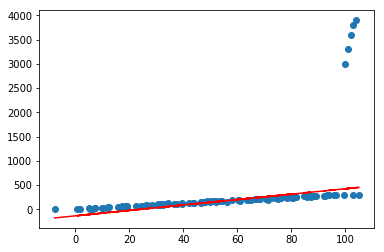

In [4]:
%matplotlib inline
lr=LinearRegression()
lr.fit(X[:,:-1],Y)
lr.plot_fit_boundary(X[:,:-1],Y)

可以发现成功省去了调节超参`alpha`的烦恼...，这样也可以发现我们上一节贝叶斯估计没法自动避免过拟合的主要原因是`alpha`是人为指定的常数，而本节由于将`alpha`也视作随机变量，并假设它来源于一个比较合理Gamma分布，最后通过求期望的方式得到一个更优的`alpha`